In [1]:
from helpers import *

In [2]:
import sys
sys.path.append('..')
import umbrella_mesh
import linkage_vis
import load_jsondata
from configuration import *
from visualization_helper import *

In [3]:
import numpy as np

In [4]:
sys.path.append('../UmbrellaGen')
import grid_gen

### Compute Geometry with Regular Grid

In [5]:
import mesh
base_mesh = mesh.Mesh("../../data/plane_equi.obj")
V, F = base_mesh.vertices(), base_mesh.elements()
V_3d = np.zeros((len(V), 3))
V_3d[:, :2] = V
edge_length = np.linalg.norm(V_3d[F][0, 0] - V_3d[F][0, 1])
numUmbrellas = len(F)

In [6]:
degree = 3
rows, cols = 0, 0
minHeight = 64

In [7]:
grid_gen.genUmbrellaWithHeights(degree, rows, cols, height_scales = height_Ux_nbCell(numUmbrellas),minHeight = minHeight, base_mesh = (V_3d.tolist(),F.tolist()), edge_length=edge_length)

### Initialization of Umbrella Class

In [8]:
name = 'grid_dump'
input_path = '../UmbrellaGen/{}.json.gz'.format(name)
io, input_data, target_mesh, curr_um, plate_thickness_scaled, target_height_multiplier = parse_input(input_path, handleBoundary = False, isHex = (degree==6), use_target_surface = False)
print(f"\
PLATE CHARACTERISTIQUES:\n\
\tplate thickness   : {input_data['thickness']}\n\
\tplate edge length : {input_data['plate_edge_length']}")

PLATE CHARACTERISTIQUES:
	plate thickness   : 0.00832632927026812
	plate edge length : 0.08326329271822491


### Undeployed Schema

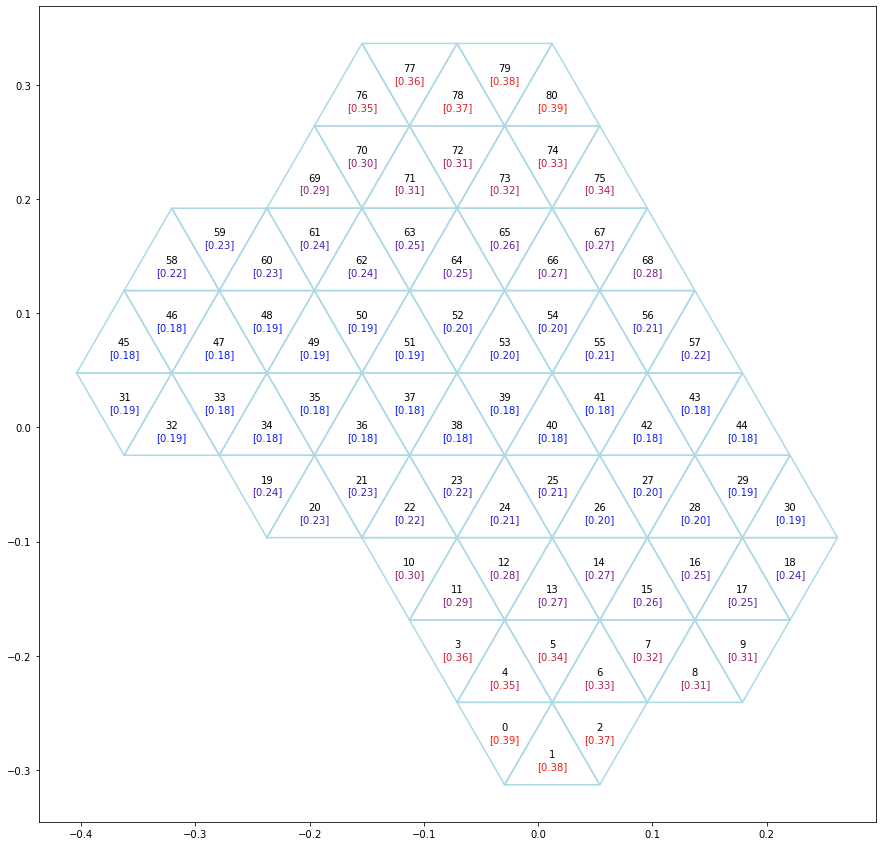

In [9]:
plot2D(input_data, curr_um, True)

### 3D Structure

In [10]:
rod_colors = get_color_field(curr_um, input_data, uidBased = True) 
lview = linkage_vis.LinkageViewer(curr_um, width=800, height=600)
lview.update(scalarField = rod_colors)
lview.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

### Set Target Height

In [11]:
# Percents
active_cells    = [0, numUmbrellas-1] # cells indexes
target_percents = [0, 100] # openning percent (0 means close cell)
target_heights = percent_to_height(curr_um, input_data['thickness'], active_cells, target_percents)

In [12]:
# VALIDATE INPUT
assert min(active_cells)>=0, 'active cells indexes should be positive'
assert max(active_cells)<curr_um.numUmbrellas(), f'active cells indexes are too big (max accepted value:{curr_um.numUmbrellas()-1})'
assert max(target_heights)*input_data['thickness']<=max(curr_um.umbrellaHeights), f'target height is too high (max accepted value:{max(curr_um.umbrellaHeights)})'

In [13]:
# Height multiple
# active_cells   = [1, 5, 300] # cells indexes
# target_heights = [1, 5, 10] # thickness multiples

### Deploy Structure

In [14]:
%%time
dep_weights              = set_actives_dep_weights(curr_um.numUmbrellas(), active_cells)
target_height_multiplier = set_target_height(curr_um.numUmbrellas(), active_cells, target_heights)
success, eqays = deploy_umbrella_pin_rigid_motion(curr_um,
                                                  plate_thickness_scaled,
                                                  target_height_multiplier,
                                                  lview, 
                                                  rod_colors,
                                                  analysis = True,
                                                  dep_weights=dep_weights)
print('success : ', success, '\n')

success :  True 

CPU times: user 1min 19s, sys: 2min 43s, total: 4min 3s
Wall time: 17.2 s


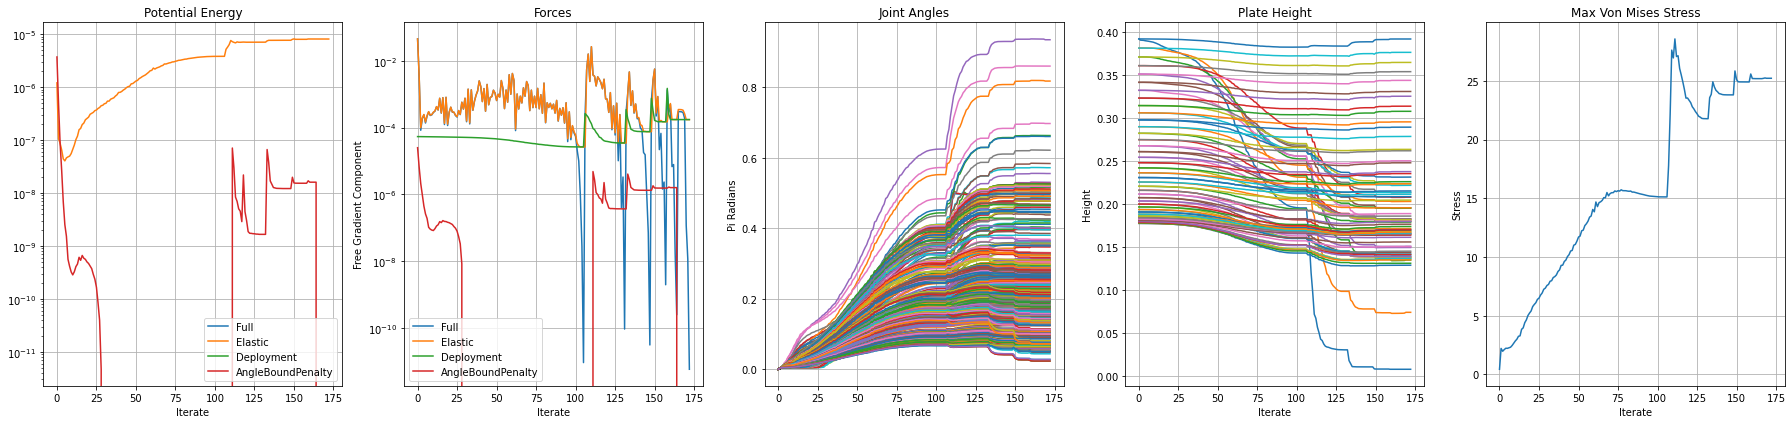

In [15]:
eqays.plot()

## Stress Visualization

In [16]:
def plot_stress(title, stress):
    sview = linkage_vis.LinkageViewer(curr_um, width=800, height=600)
    arm_stress = get_arm_stresses(curr_um, stress)
    sview.update(scalarField = arm_stress)
    print(f'{title} Stresses Extrem values:\n\
    max : {np.array(arm_stress).max():.2e}\n\
    min : {np.array(arm_stress).min():.2e}')
    return sview

---

In [17]:
sview_vm = plot_stress('Von Mises', curr_um.maxVonMisesStresses())
sview_vm.show()

Von Mises Stresses Extrem values:
    max : 2.52e+01
    min : 0.00e+00


Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

In [18]:
sview_bending = plot_stress('Bending', curr_um.maxBendingStresses())
sview_bending.show()

Bending Stresses Extrem values:
    max : 2.52e+01
    min : 0.00e+00


Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

In [19]:
sview_twisting = plot_stress('Twisting', curr_um.twistingStresses())
sview_twisting.show()

Twisting Stresses Extrem values:
    max : 4.74e+00
    min : 0.00e+00


Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…